In [1]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

/tmp/ipykernel_240057/1280679767.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# read DF

file_path = 'data/amazon_reviews.csv'  # Replace this with the path to your CSV file
df = pd.read_csv(file_path)

In [3]:
def check_df(df: pd.DataFrame, outliers_degree=2) -> str:
    """ Show for each column - how many unique values """
    fields = []
    for column in df.columns:
        non_na_values = df[column].dropna()
        d_type = df[column].dtypes  
        c_type = 'other'
        if pd.api.types.is_numeric_dtype(df[column]):   # Type of field
            c_type = 'numeric' 
        elif pd.api.types.is_string_dtype(df[column]) :
            c_type = 'string'
        unique = df[column].nunique()   # how many unique values
        nulls = df[column].isnull().sum() / len(df) # % of nulls for column
        mean_freq = df[column].dropna().mean() if c_type == 'numeric' else df[column].dropna().mode()[0] # mean (numeric), frequent for (string)
        median = df[column].dropna().median() if c_type == 'numeric' else None # median (numeric)
        std = df[column].dropna().std() if c_type == 'numeric' else None    # std (numeric)
        values, outliers, n_entropy = None, None, None
        if c_type == 'numeric':
             values = [non_na_values.min(), non_na_values.max()]    # min_max_or_categories (numeric)
             try:
                 z_scores = np.abs(stats.zscore(non_na_values))
                 # outliers = len(df[np.abs(z_scores) > outliers_degree]) / len(df)   # outliers (numeric)
                 outliers = (z_scores > outliers_degree).sum() / len(df)   # outliers (numeric)
             except TypeError as e:
                 print(f"Error calculating z-scores for column {column}: {e}")
                    
        elif c_type == 'string':     # normalized entropy for categorical (string)       
            values = {category: i for i, category in enumerate(df[column].dropna().unique())} # min_max_or_categories (categorical)
            probabilities = df[column].dropna().value_counts() / len(df)
            n_entropy = -np.sum(probabilities * np.log2(probabilities)) / np.log2(len(df[column].value_counts())) 
        fields.append([column, d_type, c_type, unique, nulls, mean_freq, median, std, n_entropy, outliers, values]) 

    c_df = pd.DataFrame(fields, columns=['name', 'd_type', 'c_type', 'unique', '%_nulls', 'mean_freq', 
                                         'median', 'std', 'n_entropy', 'outliers_%', 'min_max_or_categories'])
    return c_df

# use
guide_df = check_df(df, 3)
guide_df

,name,d_type,c_type,unique,%_nulls,mean_freq,median,std,n_entropy,outliers_%,min_max_or_categories
0,userName,object,other,131182,0.000241,Amazon Customer,NaN,NaN,NaN,NaN,None
1,verified,bool,numeric,2,0.000000,0.950325,1.0,0.217273,NaN,0.049675,"[False, True]"
2,itemName,object,other,109009,0.000002,Puppia Dog Harnesses,NaN,NaN,NaN,NaN,None
3,description,object,other,93335,0.000015,[],NaN,NaN,NaN,NaN,None
4,image,object,string,86736,0.000000,[],NaN,NaN,0.841075,NaN,{'['https://images-na.ssl-images-amazon.com/im...
5,brand,object,other,24640,0.007025,KONG,NaN,NaN,NaN,NaN,None
6,feature,object,string,78944,0.000000,[],NaN,NaN,0.774946,NaN,"{'[]': 0, '['Features Bright Pink Lemonade pat..."
7,category,object,string,16,0.000000,Pet_Supplies,NaN,NaN,0.699177,NaN,"{'Prime_Pantry': 0, 'Grocery_and_Gourmet_Food'..."
8,price,object,other,7667,0.134869,$9.99,NaN,NaN,NaN,NaN,None
9,rating,float64,numeric,5,0.000000,4.345191,5.0,1.170084,NaN,0.000000,"[1.0, 5.0]"


# The dataset contains the following columns:

userName: String, The name of the user who left the review.

verified: Indicates whether the purchase was verified.

itemName: The name of the product reviewed.

description: A description of the product.

image: URLs to product images.

brand: The brand of the product.

feature: Features of the product listed in bullet points.

category: The category of the product.

price: The price of the product at the time of the review.

rating: The rating given by the user (our target variable for prediction).

reviewTime: The date when the review was posted.

summary: A summary of the review.

reviewText: The full text of the review.

vote: The number of helpful votes the review received.

## Let's start by performing the following steps:

1. Handle missing values: For simplicity, we'll fill missing price values with the median price. Other columns with missing values that are critical to our analysis should be assessed and handled appropriately.

2. Feature engineering: Convert the price from a string to a numeric value.

3. Text processing: Combine summary and reviewText into a single text feature for analysis, and perform basic text cleaning (e.g., removing special characters, converting to lowercase).

4. Encode categorical variables: Convert verified, brand, and category into a format suitable for modeling.

In [4]:
# Firs check for duplicates and rmove them
# duplicates
df_len = len(df)
df.duplicated(keep=False).sum()
df = df.drop_duplicates(keep='first')
print(f"There are {(df_len - len(df)) / df_len * 100}% duplicates, removed")

There are 7.378814461888493% duplicates, removed


In [5]:
# imputation 
df_len = len(df)
duplicate_rows = df.isnull().any(axis=1).sum()
print(f"There are {duplicate_rows / df_len * 100}% lines with null")

There are 14.322317773119945% lines with null


In [7]:
# handle 'price' column

# First, ensure price is a string to avoid errors with replace method
df['price'] = df['price'].astype(str)

# Use regex to extract numeric values correctly and handle cases where conversion might fail
df['price'] = df['price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

# Now, fill missing values with the median price
df['price'].fillna(df['price'].median(), inplace=True)
df.head()


/tmp/ipykernel_238046/1696044303.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,12.99,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


In [6]:
# move verified (bool), brand_encoded and category_encoded to numerical values

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Encode categorical variables
df['verified'] = encoder.fit_transform(df['verified'])

df['brand_encoded'] = encoder.fit_transform(df['brand'].fillna('unknown'))
df['category_encoded'] = encoder.fit_transform(df['category'].fillna('unknown'))

# Display the first few rows to verify changes
df[['verified', 'brand_encoded', 'category_encoded', 'price']].head()

,verified,brand_encoded,category_encoded,price
0,1,21011,13,$1.63
1,1,16562,6,$6.40
2,1,15783,12,$7.99
3,0,10857,3,$14.18
4,1,15497,10,NaN


Working on verified
Working on itemName
Working on description
Working on brand
Working on category
Working on price
Working on rating
Working on reviewTime
Working on vote


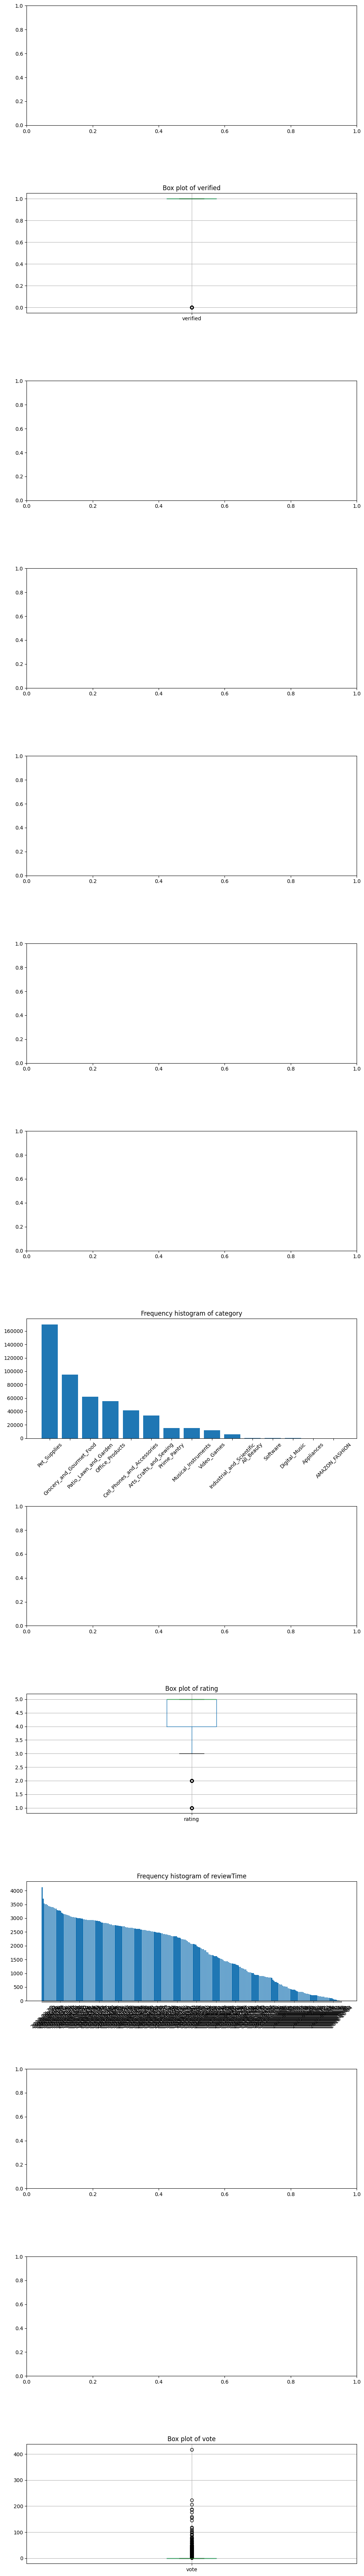

In [9]:
def plot_data_by_type(df: pd.DataFrame, guide_df: pd.DataFrame, fiter: list):
    """ One fits all plot of all the coluns """
    # Determine the number of columns for each type to set up the plot layout
    plot_df = df.dropna()
    column_types = guide_df.set_index('name')['c_type'].to_dict()
    num_plots = len(column_types)
    
    # Create a figure with subplots arranged vertically
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
    
    # Ensure axs is an array even if there's only one plot
    if num_plots == 1:
        axs = [axs]
    
    # Loop through the dictionary to plot each column according to its type
    for i, (column, col_type) in enumerate(column_types.items()):
        if column in fiter:
            continue
        print(f'Working on {column}')
        if col_type == 'numeric':
            # Plotting a box plot for numeric columns
            plot_df.boxplot(column=column, ax=axs[i])
            axs[i].set_title(f'Box plot of {column}')
        elif col_type == 'string':
            # Plotting a histogram for string columns
            category_counts = plot_df[column].value_counts()
            axs[i].bar(category_counts.index, category_counts.values)
            axs[i].set_title(f'Frequency histogram of {column}')
            axs[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# use
plot_data_by_type(df, guide_df, ['userName', 'reviewText', 'summary', 'image', 'feature'])

/tmp/ipykernel_234261/1532601674.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, palette='viridis', ax=axes[0])
/tmp/ipykernel_234261/1532601674.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


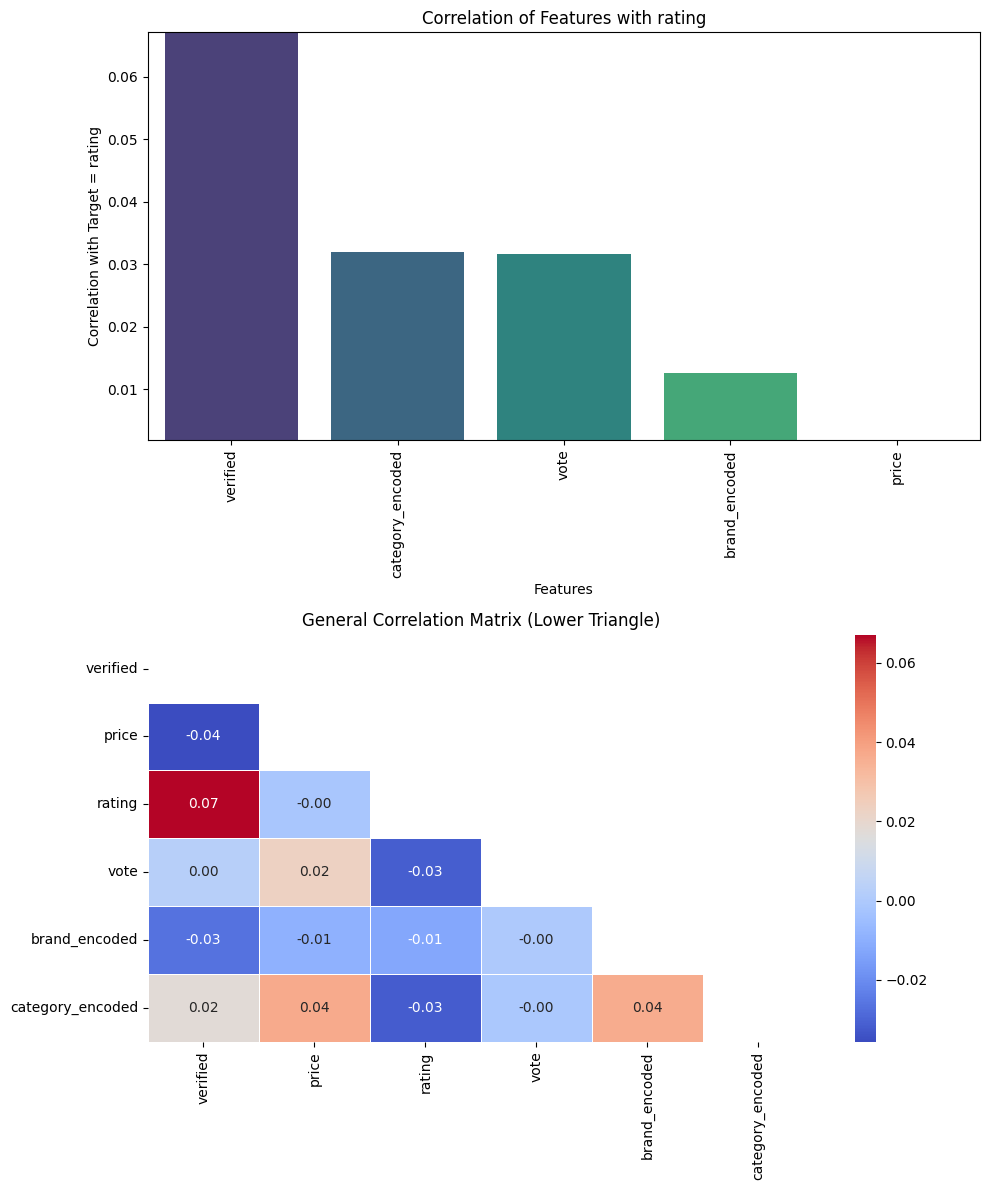

In [10]:
def full_correlation_plot(df: pd.DataFrame, target: str):
    """ Plot the correlation between each feature to the target and btween each other """
    # Calculate the correlation matrix
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    target_correlation = numeric_df.corr()[target]
    sorted_correlation = target_correlation.abs().sort_values(ascending=False).drop(target)

    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

    # Plot the correlation of features with the target variable
    sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, palette='viridis', ax=axes[0])
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel(f'Correlation with Target = {target}')
    axes[0].set_title(f'Correlation of Features with {target}')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
    axes[0].set_ylim(min(sorted_correlation), max(sorted_correlation))  # Set the y-axis limits to -1 and 1 for better visualization of correlations

    # Plot the general correlation matrix (only lower triangle)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, mask=mask, ax=axes[1])
    axes[1].set_title('General Correlation Matrix (Lower Triangle)')

    plt.tight_layout()
    plt.show()

# use - you have to send the normalized / categorical DF!
full_correlation_plot(df, target='rating')

In [7]:
# Model pre-work - split to train and test

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# Preprocessing for categorical features
categorical_features = ['verified', 'category', 'brand']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Vectorizer for 'reviewText'
text_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Applying transformations separately to allow for different preprocessing
# Encode categorical features
cat_data = df[categorical_features].fillna('Unknown')
cat_transformed = categorical_transformer.fit_transform(cat_data)

# Vectorize 'reviewText'
text_data = df['reviewText'].fillna('Unknown')
text_transformed = text_vectorizer.fit_transform(text_data)

# Combine the features: categorical and text
X_combined = hstack([cat_transformed, text_transformed])

# Split the combined features into training and testing sets
y = df['rating'].values  # Target variable
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined, y, test_size=0.2, random_state=42)

X_train_comb.shape, X_test_comb.shape

((408392, 29658), (102098, 29658))

In [12]:
# Let's try LinearRegression first

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the Linear Regression model on the enhanced feature set
linear_reg_enhanced = LinearRegression()
linear_reg_enhanced.fit(X_train_comb, y_train_comb)

# Predict on the testing set with enhanced features
y_pred_linear_enhanced = linear_reg_enhanced.predict(X_test_comb)

# Calculate the Root Mean Squared Error (RMSE) for the enhanced Linear Regression model
rmse_linear_enhanced = mean_squared_error(y_test_comb, y_pred_linear_enhanced, squared=False)

rmse_linear_enhanced

In [ ]:
# Trying with Ridg

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize and train the Ridge Regression model on the enhanced feature set
ridge_reg = Ridge()
ridge_reg.fit(X_train_comb, y_train_comb)

# Predict on the testing set with enhanced features
y_pred_ridge = ridge_reg.predict(X_test_comb)

# Calculate the Root Mean Squared Error (RMSE) for the Ridge Regression model
rmse_ridge = mean_squared_error(y_test_comb, y_pred_ridge, squared=False)

rmse_ridge

/home/user/miniconda3/envs/velotix-ex/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.879970192287131

In [1]:
# trying random forest

from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor with reduced number of estimators to manage computation
random_forest = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1, verbose=2)

# Train the model on the training set
random_forest.fit(X_train_comb, y_train_comb)

# Predict on the testing set
y_pred_rf = random_forest.predict(X_test_comb)

# Calculate the Root Mean Squared Error (RMSE) for the Random Forest model
rmse_rf = mean_squared_error(y_test_comb, y_pred_rf, squared=False)

rmse_rf

NameError: name 'X_train_comb' is not defined

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Assuming X_train_comb (sparse matrix) and y_train_comb (dense array) are defined
# For demonstration, let's create dummy sparse data and labels
# X_train_comb = csr_matrix(np.random.randint(0, 2, (10000, 100)), dtype=np.float32)
# y_train_comb = np.random.rand(10000).astype(np.float32)

# Define the batch generator function
def batch_generator(X, y, batch_size=32):
    """Yields batches of data from sparse matrix X and labels y."""
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Shuffle indices to ensure random batches
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        X_batch = X[batch_idx].toarray()  # Convert sparse matrix slice to dense
        y_batch = y[batch_idx]
        yield X_batch, y_batch

# Create a TensorFlow Dataset from the generator
def get_dataset(X, y, batch_size=32):
    return tf.data.Dataset.from_generator(
        lambda: batch_generator(X, y, batch_size),
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, X.shape[1]), (None,))
    ).prefetch(tf.data.experimental.AUTOTUNE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_comb, y_train_comb, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and validation
train_dataset = get_dataset(X_train, y_train, batch_size=32)
val_dataset = get_dataset(X_val, y_val, batch_size=32)

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Use linear activation for regression tasks
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)
history

2024-02-17 12:29:56.046112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 12:29:56.046145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 12:29:56.047177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 12:29:56.053656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 12:29:57.008903: W tensorflow/compiler/tf2

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


2024-02-17 12:29:57.738044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 12:29:57.771673: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 12:29:57.771880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/10


: 